# Tutorial

This tutorial shows the basic steps of using SEP to detect objects in an image and perform some basic aperture photometry.

Here, we use the fitsio package, just to read the test image, but you can also use astropy.io.fits for this purpose (or any other FITS reader).

In [2]:
import numpy as np
import sep

In [3]:
# additional setup for reading the test image and displaying plots
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline
rcParams['figure.figsize'] = [10., 8.]

First, we’ll read an example image from a FITS file and display it, just to show what we’re dealing with. The example image is just 256 x 256 pixels.

In [4]:
# read image into standard 2-d numpy array
data = fits.getdata('image.fits')

ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


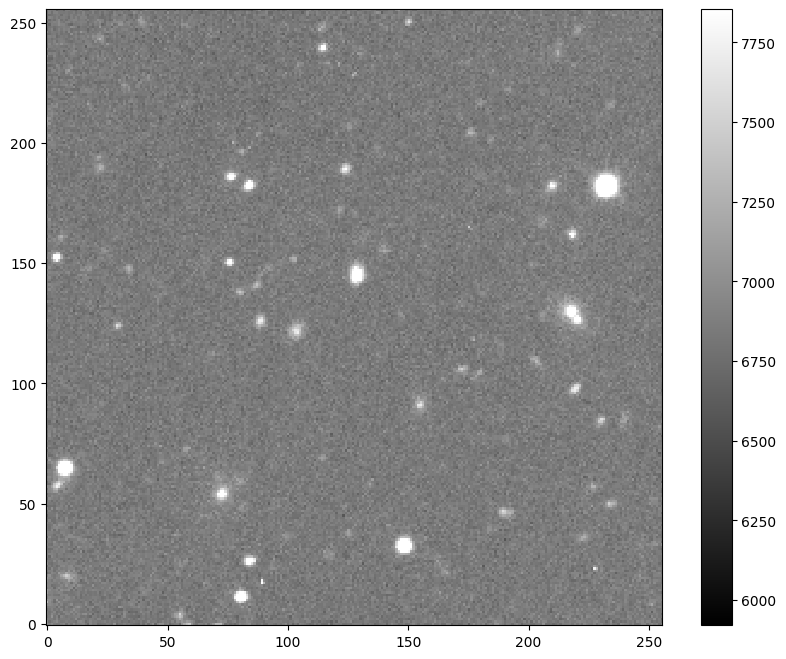

In [5]:
# show the image
m,s = np.mean(data), np.std(data)
plt.imshow(data, interpolation = 'nearest', cmap='grey', vmin = m-s, vmax = m+s, origin = 'lower')
plt.colorbar();
plt.savefig('fits_image_original.png')

# Background subtraction
Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two separate steps.

In [6]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

There are various options for controlling the box size used in estimating the background. It is also possible to mask pixels. 

This returns an Background object that holds information on the spatially varying background and spatially varying background noise level. We can now do various things with this Background object:

In [7]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


In [8]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

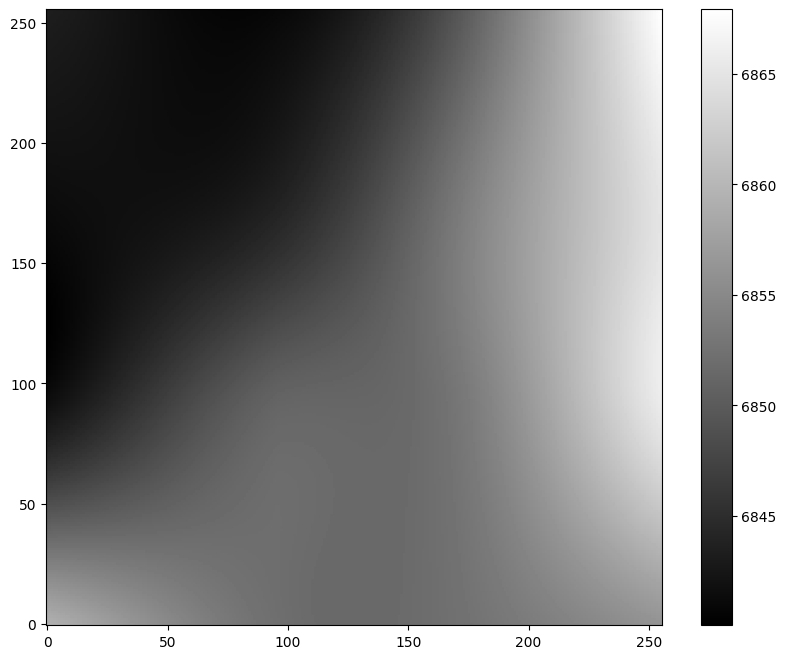

In [9]:
# show the background
plt.imshow(bkg_image, interpolation = 'nearest', cmap = 'grey', origin = 'lower')
plt.colorbar();
plt.savefig('fits_image_backgroung.png')

In [10]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

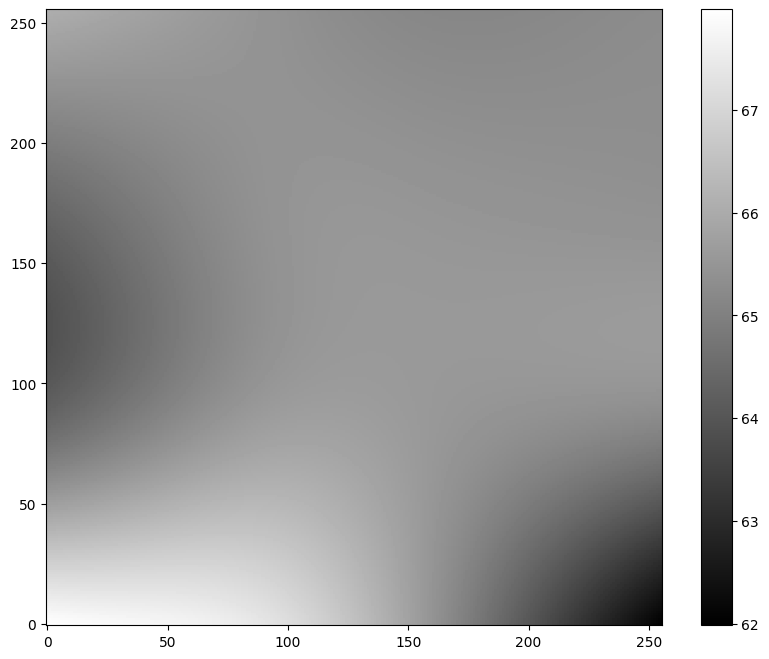

In [11]:
# show the background noise
plt.imshow(bkg_rms, interpolation = 'nearest', cmap='grey', origin = 'lower')
plt.colorbar();
plt.savefig('fits_image_background_noise.png')

In [12]:
# subtract the background
data_sub = data - bkg

One can also subtract the background from the data array in-place by doing bkg.subfrom(data).

# Object detection
Now that we’ve subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we’re setting the detection threshold to be a constant value of sigma where 1.5*sigma is the global background RMS.

In [13]:
objects = sep.extract(data_sub, 1.5, err = bkg.globalrms)

sep.extract has many options for controlling detection threshold, pixel masking, filtering, and object deblending. See the reference documentation for details.

objects is a NumPy structured array with many fields.

In [14]:
# how many objects were detected
len(objects)

69

objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detected objects are, we’ll over-plot the object coordinates with some basic shape parameters on the image:

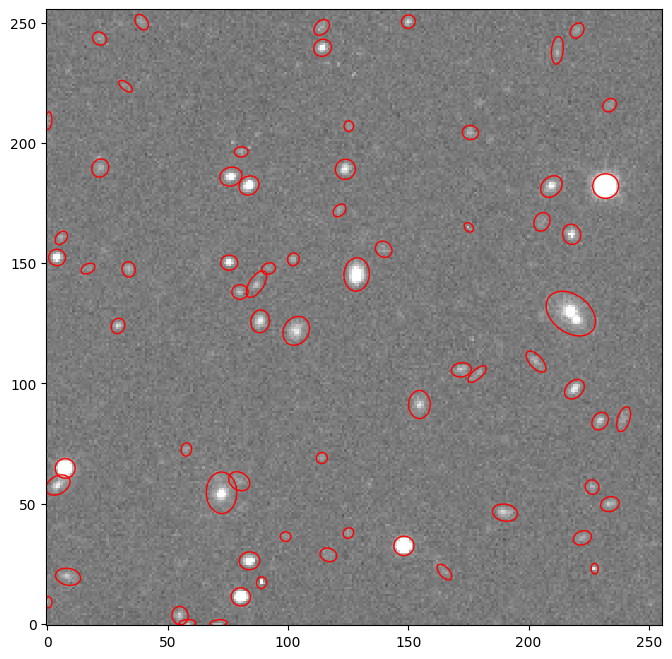

In [15]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig,ax = plt.subplots()
m,s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation = 'nearest', cmap = 'grey', vmin = m-s, vmax = m+s, origin = 'lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('fits_image_final.png')

objects has many other fields, giving information such as second moments, and peak pixel positions and values. See the reference documentation for sep.extract for descriptions of these fields. You can see the available fields:

In [16]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

# Aperture photometry
Finally, we’ll perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [25]:
flux,fluxerr,flag = sep.sum_circle(data_sub,objects['x'], objects['y'],
                                   3.0, err = bkg.globalrms, gain = 1.0)

flux, fluxerr and flag are all 1-d arrays with one entry per object.

In [26]:
# show the first 10 objects results:
for i in range(69):
    print('object {:d}: flux = {:f} +/- {:f}'.format(i, flux[i], fluxerr[i]))

object 0: flux = 2249.159297 +/- 291.027802
object 1: flux = 3092.220430 +/- 291.592204
object 2: flux = 5949.868379 +/- 356.562003
object 3: flux = 1851.426582 +/- 295.028816
object 4: flux = 72736.386914 +/- 440.172206
object 5: flux = 3860.756152 +/- 352.163162
object 6: flux = 6418.913789 +/- 357.458973
object 7: flux = 2210.707656 +/- 350.791223
object 8: flux = 2741.607227 +/- 352.277746
object 9: flux = 20916.875566 +/- 376.966138
object 10: flux = 2940.234180 +/- 351.585835
object 11: flux = 2135.050176 +/- 351.659584
object 12: flux = 263051.195430 +/- 619.177471
object 13: flux = 4205.270684 +/- 354.107137
object 14: flux = 2240.924668 +/- 351.566392
object 15: flux = 8921.247090 +/- 359.514663
object 16: flux = 5424.506680 +/- 355.342484
object 17: flux = 3408.620273 +/- 352.980473
object 18: flux = 4254.974551 +/- 353.693015
object 19: flux = 22778.135234 +/- 379.200896
object 20: flux = 11145.091387 +/- 362.830603
object 21: flux = 281617.316426 +/- 634.668347
object 22: f